In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformer = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

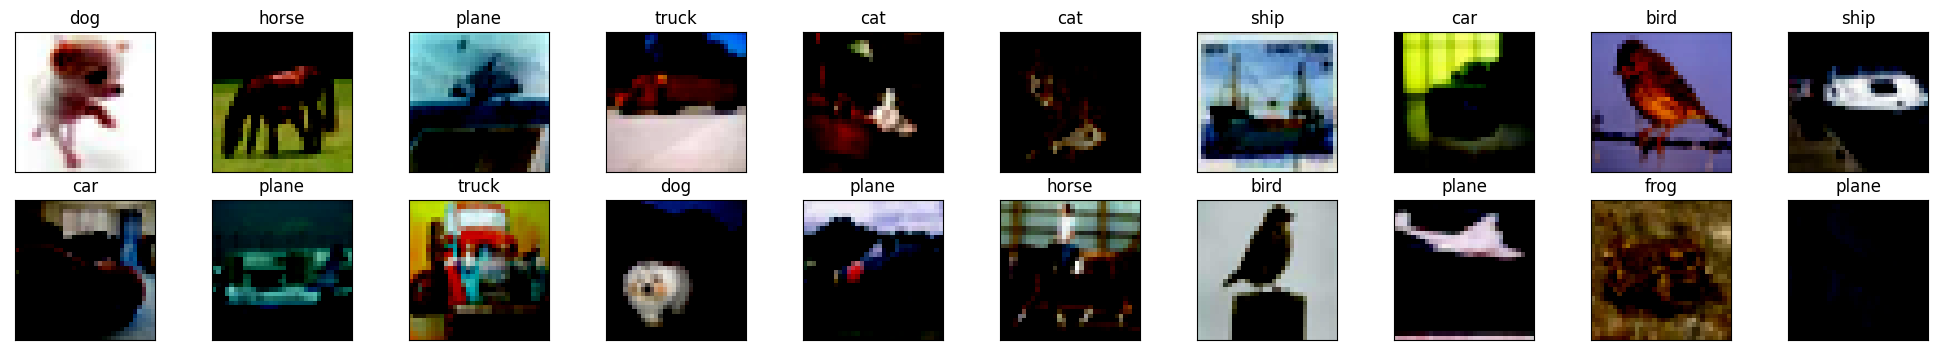

In [5]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])

In [6]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()
    # 32px 이었다가, conv를 거치면서 절반으로 감소
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [7]:
model = Net().to(device)
torch.save(model.state_dict(), 'BaseModel_weights.pth')

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 12
running_loss_history = []
running_correct_history = []
validation_running_loss_history = []
validation_running_correct_history = []

for e in range(epochs):

  running_loss = 0.0
  running_correct = 0.0
  validation_running_loss = 0.0
  validation_running_correct = 0.0

  for inputs, labels in training_loader:

    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)

    running_correct += torch.sum(preds == labels.data)
    running_loss += loss.item()



  else:
    # 훈련팔 필요가 없으므로 메모리 절약
    with torch.no_grad():

      for val_input, val_label in validation_loader:

        val_input = val_input.to(device)
        val_label = val_label.to(device)
        val_outputs = model(val_input)
        val_loss = criterion(val_outputs, val_label)

        _, val_preds = torch.max(val_outputs, 1)
        validation_running_loss += val_loss.item()
        validation_running_correct += torch.sum(val_preds == val_label.data)


    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_correct.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)

    val_epoch_loss = validation_running_loss / len(validation_loader)
    val_epoch_acc = validation_running_correct.float() / len(validation_loader)
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_correct_history.append(val_epoch_acc)

    print("===================================================")
    print("epoch: ", e + 1)
    print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc))
    print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc))

epoch:  1
training loss: 1.58677, acc: 41.890003
validation loss: 1.36305, acc: 50.480000
epoch:  2
training loss: 1.23411, acc: 55.630001
validation loss: 1.19815, acc: 57.709999
epoch:  3
training loss: 1.06641, acc: 61.926003
validation loss: 1.03857, acc: 63.789997
epoch:  4
training loss: 0.95245, acc: 66.086006
validation loss: 0.96621, acc: 66.299995
epoch:  5
training loss: 0.86813, acc: 69.528000
validation loss: 0.90677, acc: 68.479996
epoch:  6
training loss: 0.79944, acc: 71.738007
validation loss: 0.89839, acc: 69.449997
epoch:  7
training loss: 0.74138, acc: 73.688004
validation loss: 0.85311, acc: 70.699997
epoch:  8
training loss: 0.69341, acc: 75.416000
validation loss: 0.85541, acc: 71.180000
epoch:  9
training loss: 0.64741, acc: 77.140007
validation loss: 0.83827, acc: 71.809998
epoch:  10
training loss: 0.61026, acc: 78.430000
validation loss: 0.81757, acc: 72.709999
epoch:  11
training loss: 0.57423, acc: 79.434006
validation loss: 0.83127, acc: 72.830002
epoch:  